<a href="https://colab.research.google.com/github/AmlanAlok/instacart-2017-project/blob/XGBoost-2/Instacart_2017_XGBoost_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For data manipulation
import pandas as pd    
import xgboost
from sklearn.model_selection import train_test_split
import time

import pandas as pd # dataframes
import numpy as np # algebra & calculus
from google.colab import drive
drive.mount('/content/drive/')

%cd 'drive/MyDrive/9-Projects/1-ML-Instacart'


# Garbage Collector to free up memory
import gc                         
gc.enable()  

Mounted at /content/drive/
/content/drive/MyDrive/9-Projects/1-ML-Instacart


Reading input

In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")

print("aisles: ",aisles.shape)
print("departments: " ,departments.shape)
print("orders: ",orders.shape)
print("products: ",products.shape)
print("order_products_prior: ",order_products_prior.shape)
print("order_products_train: ",order_products_train.shape)

aisles:  (134, 2)
departments:  (21, 2)
orders:  (3421083, 7)
products:  (49688, 4)
order_products_prior:  (32434489, 4)
order_products_train:  (1384617, 4)


Reducing size of orders for faster computation

In [3]:
orders = orders.loc[orders.user_id.isin(orders.user_id.drop_duplicates().sample(frac=0.5, random_state=25))] 
orders.shape

(1707694, 7)

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
11,2168274,2,prior,1,2,11,NaN
12,1501582,2,prior,2,5,10,10.0
13,1901567,2,prior,3,1,10,3.0
14,738281,2,prior,4,2,10,8.0
15,1673511,2,prior,5,3,11,8.0


Changing some columns from object type to Category

In [4]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

In [6]:
op = orders.merge(order_products_prior, on='order_id', how='inner')
print('op.shape', op.shape)
op.head()

op.shape (16205726, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2168274,2,prior,1,2,11,NaN,32792,1,0
1,2168274,2,prior,1,2,11,NaN,47766,2,0
2,2168274,2,prior,1,2,11,NaN,20574,3,0
3,2168274,2,prior,1,2,11,NaN,12000,4,0
4,2168274,2,prior,1,2,11,NaN,48110,5,0


1. USER PREDICTORS




In [8]:
# Create distinct groups for each user, identify the highest order number in each group

# How many times has a user placed orders?

user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
print('user.shape =', user.shape)
print('total users in the prior dataset =', user.shape[0])
user.head()

user.shape (103104, 1)
total users in the prior dataset = 103104


,u_total_orders
user_id,
2,14
4,5
5,4
7,20
9,3


In [8]:
# Resetting index
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,2,14
1,4,5
2,5,4
3,7,20
4,9,3


In [9]:
# For a given user what is the mean of the reordered column?
# For a user, what is the ratio of reordered item to total items ordered?

u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
print('u_reorder.shape', u_reorder.shape)
u_reorder.head()

u_reorder.shape (103104, 2)


,user_id,u_reordered_ratio
0,2,0.476923
1,4,0.055556
2,5,0.378378
3,7,0.669903
4,9,0.236842


In [10]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

print('user.shape =', user.shape)
user.head()

user.shape = (103104, 3)


,user_id,u_total_orders,u_reordered_ratio
0,2,14,0.476923
1,4,5,0.055556
2,5,4,0.378378
3,7,20,0.669903
4,9,3,0.236842


2. PRODUCT PREDICTORS

In [12]:
# For each product, count the number of orders in which it was present
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
print('prd.shape =', prd.shape)
prd.head()

prd.shape = (49193, 2)


,product_id,p_total_purchases
0,1,1011
1,2,50
2,3,158
3,4,151
4,5,6


In [13]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >260)
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (14332727, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2168274,2,prior,1,2,11,NaN,32792,1,0
1,2168274,2,prior,1,2,11,NaN,47766,2,0
2,2168274,2,prior,1,2,11,NaN,20574,3,0
3,2168274,2,prior,1,2,11,NaN,12000,4,0
4,2168274,2,prior,1,2,11,NaN,48110,5,0


In [14]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (8071, 2)


,product_id,p_reorder_ratio
0,1,0.650841
1,10,0.516845
2,23,0.463588
3,25,0.639388
4,28,0.552083


In [15]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
gc.collect()

print('prd.shape =', prd.shape)
prd.head()

prd.shape = (49193, 3)


,product_id,p_total_purchases,p_reorder_ratio
0,1,1011,0.650841
1,2,50,NaN
2,3,158,NaN
3,4,151,NaN
4,5,6,NaN


In [16]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1011,0.650841
1,2,50,0.000000
2,3,158,0.000000
3,4,151,0.000000
4,5,6,0.000000


3. USER-PRODUCT PREDICTORS

In [16]:
# For a user, counting the number of products they bought of each type

uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
2       23                         1
        79                         1
        1559                       6
        2002                       4
        2573                       2

In [17]:
uxp = uxp.reset_index()
print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (6653772, 3)


,user_id,product_id,uxp_total_bought
0,2,23,1
1,2,79,1
2,2,1559,6
3,2,2002,4
4,2,2573,2


In [18]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
print('times.shape =', times.shape)
times.head()

times.shape = (6653772, 1)


Times_Bought_N
user_id product_id                
2       23                       1
        79                       1
        1559                     6
        2002                     4
        2573                     2

In [19]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders = total_orders.reset_index()
print('total_orders.shape =', total_orders.shape)
total_orders.head()

total_orders.shape = (103104, 2)


,user_id,total_orders
0,2,14
1,4,5
2,5,4
3,7,20
4,9,3


In [20]:
# Amongsnt all the orders a user placed, we are finding the order number where 
# a certain product was bought for the first time

first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no = first_order_no.reset_index()
print('first_order_no.shape =', first_order_no.shape)
first_order_no.head()

first_order_no.shape = (6653772, 3)


,user_id,product_id,first_order_number
0,2,23,8
1,2,79,13
2,2,1559,5
3,2,2002,8
4,2,2573,10


In [21]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
print('span.shape =', span.shape)
span.head()

span.shape = (6653772, 4)


,user_id,total_orders,product_id,first_order_number
0,2,14,23,8
1,2,14,79,13
2,2,14,1559,5
3,2,14,2002,8
4,2,14,2573,10


In [22]:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
print('span.shape =', span.shape)
span.head()

span.shape = (6653772, 5)


,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,2,14,23,8,7
1,2,14,79,13,2
2,2,14,1559,5,10
3,2,14,2002,8,7
4,2,14,2573,10,5


In [24]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (6653772, 6)


,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,2,23,1,14,8,7
1,2,79,1,14,13,2
2,2,1559,6,14,5,10
3,2,2002,4,14,8,7
4,2,2573,2,14,10,5


In [25]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,2,23,1,14,8,7,0.142857
1,2,79,1,14,13,2,0.500000
2,2,1559,6,14,5,10,0.600000
3,2,2002,4,14,8,7,0.571429
4,2,2573,2,14,10,5,0.400000


In [26]:
# dropping all unrequired columns

uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (6653772, 3)


,user_id,product_id,uxp_reorder_ratio
0,2,23,0.142857
1,2,79,0.500000
2,2,1559,0.600000
3,2,2002,0.571429
4,2,2573,0.400000


In [27]:
#Remove temporary DataFrames
del [times, first_order_no, span]

In [28]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio

print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (6653772, 4)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,2,23,1,0.142857
1,2,79,1,0.500000
2,2,1559,6,0.600000
3,2,2002,4,0.571429
4,2,2573,2,0.400000


MERGE ALL FEATURES

In [29]:
# Merging uxp features with the user features

data = uxp.merge(user, on='user_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (6653772, 6)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio
0,2,23,1,0.142857,14,0.476923
1,2,79,1,0.500000,14,0.476923
2,2,1559,6,0.600000,14,0.476923
3,2,2002,4,0.571429,14,0.476923
4,2,2573,2,0.400000,14,0.476923


In [30]:
# Merge uxp & user features (the new DataFrame) with prd features

data = data.merge(prd, on='product_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (6653772, 8)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,2,23,1,0.142857,14,0.476923,563,0.463588
1,2,79,1,0.500000,14,0.476923,1680,0.500595
2,2,1559,6,0.600000,14,0.476923,3572,0.732643
3,2,2002,4,0.571429,14,0.476923,1313,0.511805
4,2,2573,2,0.400000,14,0.476923,566,0.340989


In [31]:
del op, user, prd, uxp
gc.collect()

516

TRAIN DF

In [32]:
orders['eval_set'].unique()

['prior', 'train', 'test']
Categories (3, object): ['prior', 'test', 'train']

In [33]:
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
print('orders_future shape:', orders_future.shape)
orders_future.head(10)

orders_future shape: (103104, 3)


,user_id,eval_set,order_id
25,2,train,1492625
44,4,test,329954
49,5,train,2196797
74,7,train,525192
82,9,train,1094988
88,10,train,1822501
96,11,test,1376945
102,12,test,1356845
129,14,train,2316178
159,16,test,1416320


In [34]:
# bring the info of the future orders to data DF
data = data.merge(orders_future, on='user_id', how='left')
data.head(10)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,2,23,1,0.142857,14,0.476923,563,0.463588,train,1492625
1,2,79,1,0.500000,14,0.476923,1680,0.500595,train,1492625
2,2,1559,6,0.600000,14,0.476923,3572,0.732643,train,1492625
3,2,2002,4,0.571429,14,0.476923,1313,0.511805,train,1492625
4,2,2573,2,0.400000,14,0.476923,566,0.340989,train,1492625
5,2,3151,1,0.333333,14,0.476923,286,0.625874,train,1492625
6,2,4071,1,0.250000,14,0.476923,443,0.455982,train,1492625
7,2,4957,1,0.111111,14,0.476923,9959,0.739432,train,1492625
8,2,5212,1,0.142857,14,0.476923,12341,0.741593,train,1492625
9,2,5322,1,0.100000,14,0.476923,5568,0.667565,train,1492625


In [35]:
#Keep only the customers who we know what they bought in their future order
data_train = data[data.eval_set=='train']
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,2,23,1,0.142857,14,0.476923,563,0.463588,train,1492625
1,2,79,1,0.500000,14,0.476923,1680,0.500595,train,1492625
2,2,1559,6,0.600000,14,0.476923,3572,0.732643,train,1492625
3,2,2002,4,0.571429,14,0.476923,1313,0.511805,train,1492625
4,2,2573,2,0.400000,14,0.476923,566,0.340989,train,1492625


In [36]:
#Get from order_products_train all the products that the train users bought bought in their future order
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head(15)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,2,23,1,0.142857,14,0.476923,563,0.463588,train,1492625,NaN
1,2,79,1,0.500000,14,0.476923,1680,0.500595,train,1492625,NaN
2,2,1559,6,0.600000,14,0.476923,3572,0.732643,train,1492625,NaN
3,2,2002,4,0.571429,14,0.476923,1313,0.511805,train,1492625,NaN
4,2,2573,2,0.400000,14,0.476923,566,0.340989,train,1492625,NaN
5,2,3151,1,0.333333,14,0.476923,286,0.625874,train,1492625,NaN
6,2,4071,1,0.250000,14,0.476923,443,0.455982,train,1492625,NaN
7,2,4957,1,0.111111,14,0.476923,9959,0.739432,train,1492625,NaN
8,2,5212,1,0.142857,14,0.476923,12341,0.741593,train,1492625,NaN
9,2,5322,1,0.100000,14,0.476923,5568,0.667565,train,1492625,NaN


In [37]:
data_train['reordered'].unique()

array([nan,  1.])

In [38]:
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head(15)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,2,23,1,0.142857,14,0.476923,563,0.463588,train,1492625,0.0
1,2,79,1,0.500000,14,0.476923,1680,0.500595,train,1492625,0.0
2,2,1559,6,0.600000,14,0.476923,3572,0.732643,train,1492625,0.0
3,2,2002,4,0.571429,14,0.476923,1313,0.511805,train,1492625,0.0
4,2,2573,2,0.400000,14,0.476923,566,0.340989,train,1492625,0.0
5,2,3151,1,0.333333,14,0.476923,286,0.625874,train,1492625,0.0
6,2,4071,1,0.250000,14,0.476923,443,0.455982,train,1492625,0.0
7,2,4957,1,0.111111,14,0.476923,9959,0.739432,train,1492625,0.0
8,2,5212,1,0.142857,14,0.476923,12341,0.741593,train,1492625,0.0
9,2,5322,1,0.100000,14,0.476923,5568,0.667565,train,1492625,0.0


In [39]:
#We set user_id and product_id as the index of the DF
data_train = data_train.set_index(['user_id', 'product_id'])
data_train.head(15)

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
2       23                         1           0.142857              14   
        79                         1           0.500000              14   
        1559                       6           0.600000              14   
        2002                       4           0.571429              14   
        2573                       2           0.400000              14   
        3151                       1           0.333333              14   
        4071                       1           0.250000              14   
        4957                       1           0.111111              14   
        5212                       1           0.142857              14   
        5322                       1           0.100000              14   
        5450                       1           0.166667              14   
        5869                       1           0.500000              14   
        5907                       1           0.100000              14   
        7781                       3           0.250000              14   
        7963                       1           1.000000              14   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
2       23                   0.476923                563         0.463588   
        79                   0.476923               1680         0.500595   
        1559                 0.476923               3572         0.732643   
        2002                 0.476923               1313         0.511805   
        2573                 0.476923                566         0.340989   
        3151                 0.476923                286         0.625874   
        4071                 0.476923                443         0.455982   
        4957                 0.476923               9959         0.739432   
        5212                 0.476923              12341         0.741593   
        5322                 0.476923               5568         0.667565   
        5450                 0.476923              24962         0.680154   
        5869                 0.476923                 56         0.000000   
        5907                 0.476923                247         0.000000   
        7781                 0.476923              17492         0.734793   
        7963                 0.476923               6675         0.671461   

                   eval_set  order_id  reordered  
user_id product_id                                
2       23            train   1492625        0.0  
        79            train   1492625        0.0  
        1559          train   1492625        0.0  
        2002          train   1492625        0.0  
        2573          train   1492625        0.0  
        3151          train   1492625        0.0  
        4071          train   1492625        0.0  
        4957          train   1492625        0.0  
        5212          train   1492625        0.0  
        5322          train   1492625        0.0  
        5450          train   1492625        1.0  
        5869          train   1492625        0.0  
        5907          train   1492625        0.0  
        7781          train   1492625        0.0  
        7963          train   1492625        1.0

In [40]:
#We remove all non-predictor variables
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head(15)

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
2       23                         1           0.142857              14   
        79                         1           0.500000              14   
        1559                       6           0.600000              14   
        2002                       4           0.571429              14   
        2573                       2           0.400000              14   
        3151                       1           0.333333              14   
        4071                       1           0.250000              14   
        4957                       1           0.111111              14   
        5212                       1           0.142857              14   
        5322                       1           0.100000              14   
        5450                       1           0.166667              14   
        5869                       1           0.500000              14   
        5907                       1           0.100000              14   
        7781                       3           0.250000              14   
        7963                       1           1.000000              14   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
2       23                   0.476923                563         0.463588   
        79                   0.476923               1680         0.500595   
        1559                 0.476923               3572         0.732643   
        2002                 0.476923               1313         0.511805   
        2573                 0.476923                566         0.340989   
        3151                 0.476923                286         0.625874   
        4071                 0.476923                443         0.455982   
        4957                 0.476923               9959         0.739432   
        5212                 0.476923              12341         0.741593   
        5322                 0.476923               5568         0.667565   
        5450                 0.476923              24962         0.680154   
        5869                 0.476923                 56         0.000000   
        5907                 0.476923                247         0.000000   
        7781                 0.476923              17492         0.734793   
        7963                 0.476923               6675         0.671461   

                    reordered  
user_id product_id             
2       23                0.0  
        79                0.0  
        1559              0.0  
        2002              0.0  
        2573              0.0  
        3151              0.0  
        4071              0.0  
        4957              0.0  
        5212              0.0  
        5322              0.0  
        5450              1.0  
        5869              0.0  
        5907              0.0  
        7781              0.0  
        7963              1.0

In [41]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4252750 entries, (2, 23) to (206203, 48364)
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uxp_total_bought   int64  
 1   uxp_reorder_ratio  float64
 2   u_total_orders     int64  
 3   u_reordered_ratio  float64
 4   p_total_purchases  int64  
 5   p_reorder_ratio    float64
 6   reordered          float64
dtypes: float64(4), int64(3)
memory usage: 263.5 MB


TEST DF 

In [42]:
#Keep only the future orders from customers who are labelled as test
data_test = data[data.eval_set=='test']
data_test.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
102,4,1200,1,0.333333,5,0.055556,406,0.418719,test,329954
103,4,2707,1,0.200000,5,0.055556,1188,0.345118,test,329954
104,4,7160,1,0.250000,5,0.055556,92,0.000000,test,329954
105,4,7350,1,0.200000,5,0.055556,1747,0.749857,test,329954
106,4,11865,1,0.333333,5,0.055556,1146,0.573298,test,329954


In [43]:
#We set user_id and product_id as the index of the DF
data_test = data_test.set_index(['user_id', 'product_id'])
data_test.head()

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
4       1200                       1           0.333333               5   
        2707                       1           0.200000               5   
        7160                       1           0.250000               5   
        7350                       1           0.200000               5   
        11865                      1           0.333333               5   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
4       1200                 0.055556                406         0.418719   
        2707                 0.055556               1188         0.345118   
        7160                 0.055556                 92         0.000000   
        7350                 0.055556               1747         0.749857   
        11865                0.055556               1146         0.573298   

                   eval_set  order_id  
user_id product_id                     
4       1200           test    329954  
        2707           test    329954  
        7160           test    329954  
        7350           test    329954  
        11865          test    329954

In [44]:
data_test = data_test.drop(['eval_set','order_id'], axis=1)
data_test.head()

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
4       1200                       1           0.333333               5   
        2707                       1           0.200000               5   
        7160                       1           0.250000               5   
        7350                       1           0.200000               5   
        11865                      1           0.333333               5   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  
user_id product_id                                                         
4       1200                 0.055556                406         0.418719  
        2707                 0.055556               1188         0.345118  
        7160                 0.055556                 92         0.000000  
        7350                 0.055556               1747         0.749857  
        11865                0.055556               1146         0.573298

In [45]:
#Check if the data_test DF, has the same number of columns as the data_train DF, excluding the response variable
data_test.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2401022 entries, (4, 1200) to (206207, 49044)
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uxp_total_bought   int64  
 1   uxp_reorder_ratio  float64
 2   u_total_orders     int64  
 3   u_reordered_ratio  float64
 4   p_total_purchases  int64  
 5   p_reorder_ratio    float64
dtypes: float64(3), int64(3)
memory usage: 130.9 MB


Build Model

In [46]:
import xgboost
from sklearn.model_selection import train_test_split
data_train.loc[:, 'reordered'] = data_train.reordered.fillna(0)
data_train.head()

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
2       23                         1           0.142857              14   
        79                         1           0.500000              14   
        1559                       6           0.600000              14   
        2002                       4           0.571429              14   
        2573                       2           0.400000              14   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
2       23                   0.476923                563         0.463588   
        79                   0.476923               1680         0.500595   
        1559                 0.476923               3572         0.732643   
        2002                 0.476923               1313         0.511805   
        2573                 0.476923                566         0.340989   

                    reordered  
user_id product_id             
2       23                0.0  
        79                0.0  
        1559              0.0  
        2002              0.0  
        2573              0.0

In [47]:
########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, X_val, y_train, y_val = train_test_split(data_train.drop('reordered', axis=1), data_train.reordered,
                                                    test_size=0.2, random_state=42)

[0]	train-logloss:0.631898
[10]	train-logloss:0.338404
[20]	train-logloss:0.273429
[30]	train-logloss:0.25727
[40]	train-logloss:0.253716
[50]	train-logloss:0.252462
[60]	train-logloss:0.251921
[70]	train-logloss:0.251656
[79]	train-logloss:0.251502


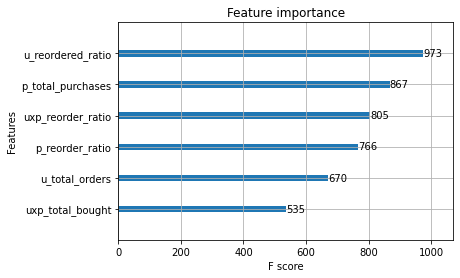

In [48]:
############################
## INITIATE AND TRAIN MODEL
############################

d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [49]:
del [X_train, X_val, y_train, y_val]
gc.collect()

50

In [50]:
pred = xgboost.DMatrix(data_test)

prediction = data_test.reset_index()
prediction = prediction[['product_id', 'user_id']]

prediction["reordered"] = (bst.predict(pred) > 0.15).astype(int)
prediction

,product_id,user_id,reordered
0,1200,4,0
1,2707,4,0
2,7160,4,0
3,7350,4,0
4,11865,4,0
...,...,...,...
2401017,47766,206207,0
2401018,48061,206207,0
2401019,48086,206207,1
2401020,48679,206207,0


In [51]:
orders_test = orders[orders.eval_set=='test']
prediction = prediction.merge(orders_test[["user_id", "order_id"]], on='user_id', how='left')
prediction.head(25)

,product_id,user_id,reordered,order_id
0,1200,4,0,329954
1,2707,4,0,329954
2,7160,4,0,329954
3,7350,4,0,329954
4,11865,4,0,329954
5,17769,4,0,329954
6,19057,4,0,329954
7,21573,4,0,329954
8,22199,4,0,329954
9,25146,4,0,329954


In [52]:
# #Save the prediction in a new column in the data_test DF
# del orders
# del orders_test
# gc.collect()

In [53]:
# prediction['product_id'] = prediction.product_id.astype(int)
# prediction = prediction.drop('user_id', axis=1)
# gc.collect()

In [54]:
# prediction